In [1]:
from tensorflow import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam, RMSprop

import numpy as np
import random
from collections import deque

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
import os
import sys
import time
import pandas as pd
import pickle

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

In [4]:
from pnl_calc import PnLcalculator

### Set the Parameters

In [5]:
state_size = 2
action_size = 3 # -1, 0, 1

In [6]:
batch_size = 32 # for Gradient descent
Nshort=5
Nlong=20

### Creating a directory to store results

In [7]:
output_dir = 'Original5-gamma0.9-learning0.01-decay0.9'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size): ## Hyperparameters for out problem
        self.state_size = state_size
        self.action_size = action_size
        self.inventory = 0   #max restriction of 10
        self.memory = deque(maxlen = 1000)
        self.gamma = 0.9 #discount rate for future rewards 
        self.epsilon = 1 #exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9
        
        self.learning_rate = 0.001 #SGD learning rate (step size for SGD Optimizer)
        
        self.model = self._build_model()
    
    def set_default(self):
        self.inventory = 0
#         self.epsilon = 1
        self.memory = deque(maxlen = 1000)
    
    
    def _build_model(self):   ## The Neural Network we will be using to estimate the function
        model = Sequential()
        model.add(Dense(units = 4, input_dim=self.state_size, activation="relu"))
        #model.add(Dropout(0.2))
#         model.add(Dense(units = 8, activation="relu"))
        #model.add(Dropout(0.2))
        #model.add(Dense(units=8, activation="relu"))
        model.add(Dense(self.action_size, activation = "linear"))
        model.compile(loss = "mse", optimizer = Adam(lr = self.learning_rate))
        
        return model
    
    def remember(self, state, action, rewards, next_state,done): #store in memory
        self.memory.append((state, action, rewards, next_state,done))
        
    def act(self, state,test): #based on exploration rate, pick a random action, or choose the optimal action
        if test == True:
            act_num = self.model.predict(state)
            return act_num[0]

        if np.random.rand() <= self.epsilon:
            return random.randrange(action_size)
        
        act_num = self.model.predict(state)
        
        #print(act_num[0])
        return act_num[0] #the action determined to be the best choice
    
    
    def replay(self, batch_size):
        start_timei = time.time()
        minibatch = random.sample(self.memory, batch_size)
#         print(minibatch)
#         print([list(x[0][0]) for x in minibatch])
        
        state_array = np.reshape([list(x[0][0]) for x in minibatch],[batch_size,self.state_size])
        action_list = [x[1] for x in minibatch]
        reward_array = np.array([x[2] for x in minibatch])
        next_state_array = np.reshape([list(x[3][0]) for x in minibatch],[batch_size,self.state_size])
        
        target = reward_array + self.gamma*np.array([max(x) for x in self.model.predict(next_state_array)]) 
        
        current_target = self.model.predict(state_array)
        
        i = 0
        
        for x in action_list:
            current_target[i,x] = target[i]  #update current target with the optimal one q*
            i+=1
           
        self.model.fit(state_array, current_target, batch_size = batch_size,epochs=1, verbose=0)
        #print(time.time() - start_timei, "after fit")
        
    def load(self, name):
        self.model.load_weights(name)
        
    def save(self, name):
        self.model.save_weights(name)       

In [9]:
# agent = DQNAgent(state_size, action_size)
# agent.load(output_dir + "/weights_20000_20.hdf5")
def evaluate(agent, validation):
    if validation == True:
        global clob,Nshort,Nlong
        
        num_train = int(len(clob)*0.6)
        test_data = clob[num_train+1:].reset_index(drop=True)  #Validation Set
        
    else:
        test_set = 'sample_data_20200901_1_test.csv'
        test_data = pd.read_csv(test_set)

    test_data['MidPrice'] = (test_data['bidPrice'] + test_data['offerPrice'])/2

    test_data['MA5'] = test_data['MidPrice'].rolling(window=Nshort).mean()
    test_data['MA20'] = test_data['MidPrice'].rolling(window=Nlong).mean()
    tprice5 = test_data['MA5'] 
    tprice20 = test_data['MA20'] 
    bid = test_data['bidPrice']
    offer = test_data['offerPrice']
    
    n_episodes = len(test_data)
    state_size = 2

    store_action = [] #for calculating PnL {7:-10, 6:-5, 5:-1, 4:0, 3:1, 2:5, 1:10}
    store_action_list = []
    action_pos =  {0:-1, 1:0, 2:1}
    agent.inventory = 0
    start_time = time.time()
    pnl_calc = []
    for step in range(state_size+4, int(n_episodes)):
        state = [(tprice5[step]-98)/4,(tprice20[step]-98)/4]
            
        state = np.reshape(list(state), [1,state_size])

        action_list = agent.act(state, True)
        action = np.argmax(action_list)
        store_action.append([action-1])
        store_action_list.append(action_list)

        pnl_calc.append(action-1)
        pos_siz = action_pos[action]
#         if step%1000==0:
#             print(time.time() - start_time)
    actiondf = pnl_calc
#     print(actiondf)
    reward, pnl = PnLcalculator(actiondf,test_data)
    print(np.cumsum(pnl))
    return store_action, store_action_list,reward,pnl

In [10]:
clob = pd.read_csv('sample_data_20200901.csv')

clob['MidPrice'] = (clob['bidPrice'] + clob['offerPrice'])/2

clob['Change_MidPrice'] = clob['MidPrice'].diff()



clob['MA5'] = clob['MidPrice'].rolling(window=Nshort).mean()   
clob['MA20'] = clob['MidPrice'].rolling(window=Nlong).mean()

price5 = list(clob['MA5'])
price20 = list(clob['MA20'])

In [11]:
agent = DQNAgent(state_size, action_size)

## Interacting with the env

In [12]:
n_episodes = len(clob)*0.6  #60% of Whole dataset (including for lookback period)

In [14]:
n_episodes

21600.0

In [15]:
step = 19
[price5[step],price20[step]]

[100.36000000000004, 100.25000000000001]

In [16]:
tracking_reward = {}
action_track = {}
action_pos = {0:-1, 1:0, 2:1}
agent = DQNAgent(state_size, action_size)
batch_size = 32
done = False
a= {}
al = {}
p = {}
h = {}
r={}
init_buffer = 19 #longer MA period
for i in range(20):
    cash = 0
    asset = 0
    tracking_reward[i] = []
    action_track[i] = []
    agent.set_default()
    begin_time = time.time()
    start_time = time.time()
    for step in range(state_size+init_buffer, int(n_episodes)-1):
       
        state = [(price5[step]-98)/4,(price20[step]-98)/4]
        
        state = np.reshape(list(state), [1,state_size])

        action_list = agent.act(state,False)
        action = np.argmax(action_list)
        action_track[i].append(action_list)
        pos_siz = action_pos[action]

        reward = pos_siz*(price5[step+1] - price5[step])
     
        # if (agent.inventory + pos_siz <= 10) and (agent.inventory + pos_siz >= -10):
        #     agent.inventory += pos_siz
        #     reward = agent.inventory*(price20[step+1] - price20[step])
        # else:
        #     #print("not allowed")
        #     reward = -20

        #print("Reward:",reward, "Cash:",cash, "Asset:",asset, "Position:",pos_siz, "Inventory:",agent.inventory)
        tracking_reward[i].append(reward)

        next_state = [(price5[step+1]-98)/4,(price20[step+1]-98)/4]
        next_state = np.reshape(list(next_state), [1,state_size])

        if step == (int(n_episodes)-1):
            done = True

        agent.remember(state, action, reward, next_state, done)
        #print(time.time() - start_time)
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
            

       # print(time.time() - start_time,"replay")
        
        if step%5000==0:
            print(" Iteration: {}/{}, score: {:.4f}, eps: {}, time: {:.2f}".format(step,int(n_episodes),sum(tracking_reward[i]),agent.epsilon,time.time() - start_time))
            start_time = time.time()
            agent.save(output_dir + "/weights_" + '{:04d}'.format(step) + "_" + str(i) + ".hdf5")

    if agent.epsilon > agent.epsilon_min:   #decrease the exploration rate for future runs
            agent.epsilon *= agent.epsilon_decay  
    

    a[i],al[i],r[i],p[i] = evaluate(agent,True)
    print(" Iteration: {}/20, score: {:.4f}, eps: {}, time: {:.2f}".format(i+1,sum(tracking_reward[i]),agent.epsilon,time.time() - begin_time))
#     plot_result(clob,agent)
store_results = {1:a, 2:al,3:p,4:h,5:tracking_reward,6:action_track}

with open(output_dir+'.pickle','wb') as f:
    pickle.dump(store_results,f)





 Iteration: 5000/21600, score: 0.1000, eps: 1, time: 40.31
 Iteration: 10000/21600, score: 0.2400, eps: 1, time: 37.42
 Iteration: 15000/21600, score: -0.0400, eps: 1, time: 35.13
 Iteration: 20000/21600, score: 0.0800, eps: 1, time: 32.22
[  0.   0.   0. ...   0.   0. -20.]
 Iteration: 1/20, score: 0.4000, eps: 0.9, time: 177.99
 Iteration: 5000/21600, score: 1.0800, eps: 0.9, time: 33.86
 Iteration: 10000/21600, score: 2.4600, eps: 0.9, time: 33.88
 Iteration: 15000/21600, score: 2.8800, eps: 0.9, time: 32.99
 Iteration: 20000/21600, score: 4.6600, eps: 0.9, time: 32.40
[0.   0.   0.   ... 9.55 9.55 9.65]
 Iteration: 2/20, score: 5.3800, eps: 0.81, time: 167.78
 Iteration: 5000/21600, score: 5.2800, eps: 0.81, time: 33.59
 Iteration: 10000/21600, score: 10.9400, eps: 0.81, time: 33.71
 Iteration: 15000/21600, score: 14.2000, eps: 0.81, time: 33.67
 Iteration: 20000/21600, score: 19.6600, eps: 0.81, time: 33.92
[ 0.   0.   0.  ... 67.6 67.6 67.7]
 Iteration: 3/20, score: 21.7200, ep

 Iteration: 5000/21600, score: 23.7600, eps: 0.13508517176729928, time: 24.68
 Iteration: 10000/21600, score: 48.2800, eps: 0.13508517176729928, time: 24.84
 Iteration: 15000/21600, score: 67.0200, eps: 0.13508517176729928, time: 24.78
 Iteration: 20000/21600, score: 92.1800, eps: 0.13508517176729928, time: 24.07
[ 0.    0.    0.   ... 64.05 64.05 64.15]
 Iteration: 20/20, score: 99.3200, eps: 0.12157665459056936, time: 118.41


## test model

In [16]:
f1 = open(output_dir+'.pickle', 'rb')
store_results=pickle.load(f1)
f1.close()

In [17]:
actions = store_results[1]    
qvalue_actions = store_results[2]
pnl = store_results[3]
history = store_results[4]
training = store_results[5]

In [18]:
agent.load(output_dir + "/weights_20000_19.hdf5")

# a,al,p,h = evaluate(agent,False)

In [19]:
a,al,p,h = evaluate(agent,False)

[  0.    0.    0.  ... 204.1 204.1 204.2]


In [20]:
test = pd.read_csv('sample_data_20200901_1_test.csv')

test['MidPrice'] = (test['bidPrice'] + test['offerPrice'])/2

test['MA5'] = test['MidPrice'].rolling(window=5).mean()   # short MA
test['MA20'] = test['MidPrice'].rolling(window=10).mean()   # long MA

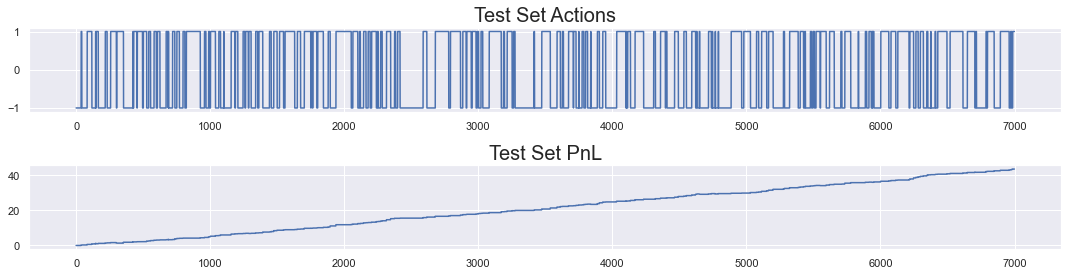

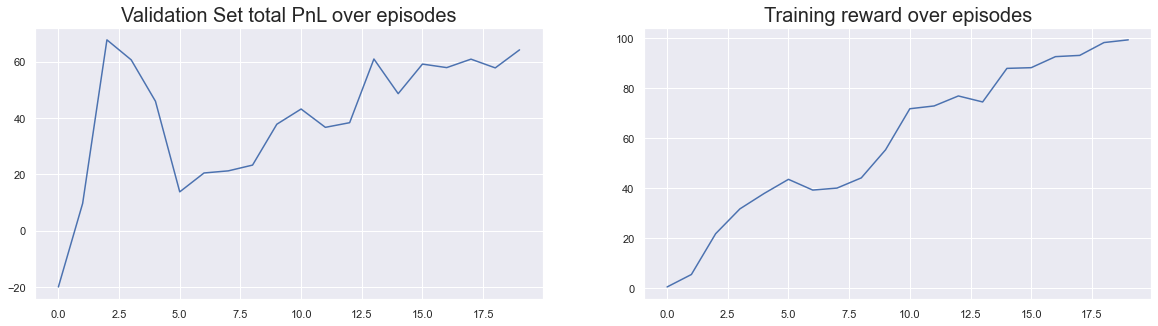

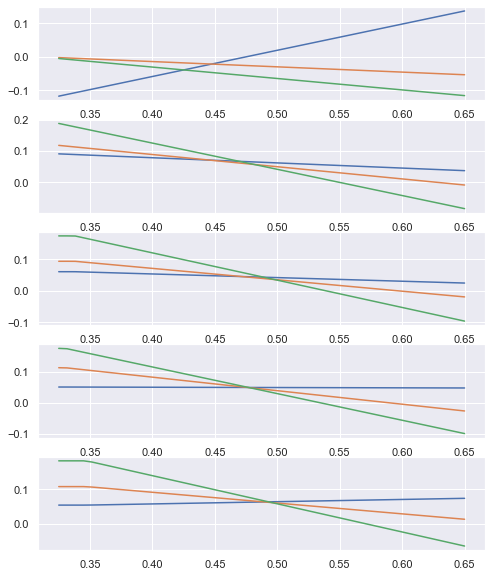

In [24]:
start_time,end_time = 1000,8000

plt.figure(figsize = (15,4))
plt.figure(1)

plt.subplot(211)
plt.plot(np.array(a[start_time:end_time]))
plt.title( "Test Set Actions", fontdict = {'fontsize' : 20})

plt.subplot(212)
plt.plot(np.cumsum(h[start_time:end_time]))
plt.title( "Test Set PnL", fontdict = {'fontsize' : 20})
plt.tight_layout()
plt.show()

plt.figure(figsize = (20,5))

plt.subplot(121)
plt.plot([sum(pnl[x]) for x in range(20)])
plt.title( "Validation Set total PnL over episodes", fontdict = {'fontsize' : 20})

plt.subplot(122)
plt.plot([sum(training[x]) for x in range(20)])
plt.title("Training reward over episodes", fontdict = {'fontsize' : 20})
plt.show()

agent_test = DQNAgent(state_size, action_size)
plt.figure(figsize = (8,10))
plt.figure(1)
numb=1

for i in [0,5,10,15,19]:
    plt.subplot(510+numb)
    numb+=1

    agent_test.load(output_dir + "/weights_20000_"+str(i)+".hdf5")
    mid=np.array(clob["MidPrice"])
    state1=(np.linspace(min(price5[5:]),max(price5[5:]))-98)/4
    state2=(np.linspace(min(price20[20:]),max(price20[20:]))-98)/4
    statemtx=pd.DataFrame(state1,state2).reset_index()
    actdf=[]
    statemtx.apply(lambda x:actdf.append(agent_test.model.predict(np.reshape(list(x),[1,2]))[0]),axis=1)
    actdf=pd.DataFrame(actdf)
    actdf.columns=["-1","0","1"]
    actdf.index=(np.linspace(min(mid[5:]),max(mid[5:]))-98)/4
    plt.plot(actdf)

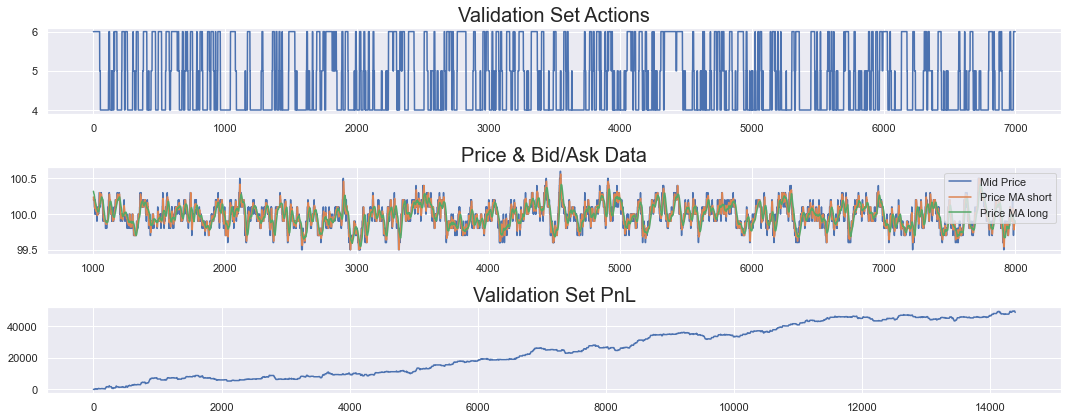

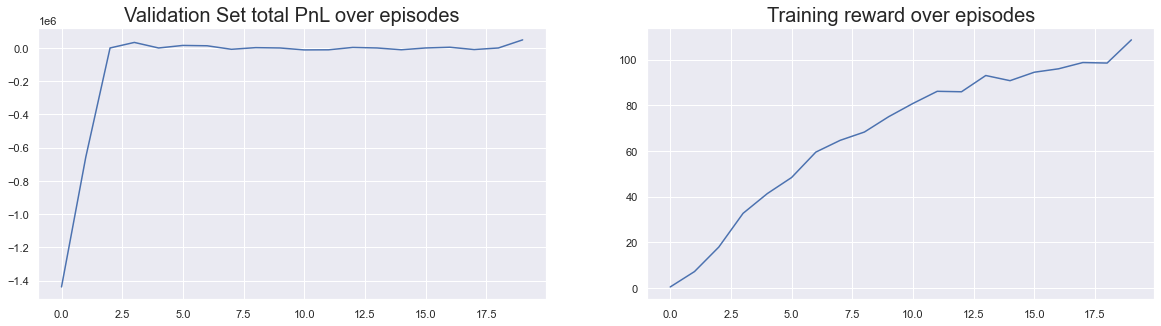

In [32]:
episode = 19
start_time,end_time = 1000,8000

plt.figure(figsize = (15,6))
plt.figure(1)

plt.subplot(311)
plt.plot(5- np.array(actions[episode][start_time:end_time]))
plt.title( "Validation Set Actions", fontdict = {'fontsize' : 20})

plt.subplot(312)
# plt.plot(clob['bidPrice'][start_time:end_time] , label = 'selling price')
# plt.plot(clob['offerPrice'][start_time:end_time] , label = 'buying price')
plt.plot(clob['MidPrice'][start_time:end_time], label = 'Mid Price')
plt.plot(clob['MA5'][start_time:end_time], label = 'Price MA short')
plt.plot(clob['MA20'][start_time:end_time], label = 'Price MA long')
# plt.plot(clob['MACD'], label = 'Price MA short')
plt.legend(loc= 'best')
plt.title( "Price & Bid/Ask Data", fontdict = {'fontsize' : 20})

plt.subplot(313)
plt.plot(np.cumsum(pnl[episode]))
plt.title( "Validation Set PnL", fontdict = {'fontsize' : 20})
plt.tight_layout()
plt.show()

plt.figure(figsize = (20,5))

plt.subplot(121)
plt.plot([sum(pnl[x]) for x in range(20)])
plt.title( "Validation Set total PnL over episodes", fontdict = {'fontsize' : 20})

plt.subplot(122)
plt.plot([sum(training[x]) for x in range(20)])
plt.title("Training reward over episodes", fontdict = {'fontsize' : 20})
plt.show()

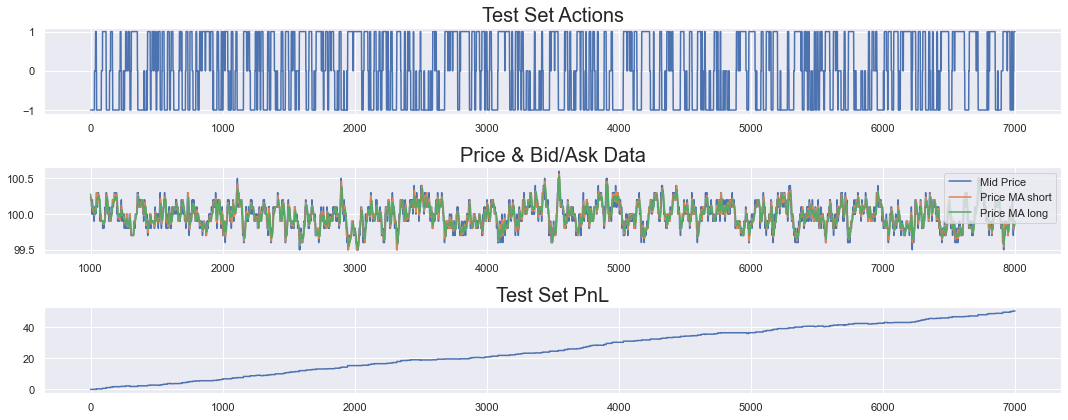

In [33]:
start_time,end_time = 1000,8000

plt.figure(figsize = (15,6))
plt.figure(1)

plt.subplot(311)
plt.plot(np.array(a[start_time:end_time]))
plt.title( "Test Set Actions", fontdict = {'fontsize' : 20})

plt.subplot(312)
# plt.plot(clob['bidPrice'][start_time:end_time] , label = 'selling price')
# plt.plot(clob['offerPrice'][start_time:end_time] , label = 'buying price')
plt.plot(test['MidPrice'][start_time:end_time], label = 'Mid Price')
plt.plot(test['MA5'][start_time:end_time], label = 'Price MA short')
plt.plot(test['MA20'][start_time:end_time], label = 'Price MA long')
# plt.plot(clob['MACD'], label = 'Price MA short')
plt.legend(loc= 'best')
plt.title( "Price & Bid/Ask Data", fontdict = {'fontsize' : 20})

plt.subplot(313)
plt.plot(np.cumsum(h[start_time:end_time]))
plt.title( "Test Set PnL", fontdict = {'fontsize' : 20})
plt.tight_layout()
plt.show()

d:\python\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
d:\python\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


[]

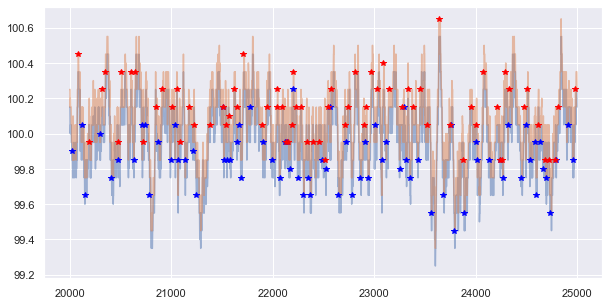

In [24]:
start=20000
end=25000
tbid=pd.DataFrame(test["bidPrice"])[6:].reset_index(drop=True)[start:end]
toffer=pd.DataFrame(test["offerPrice"])[6:].reset_index(drop=True)[start:end]
# plt.figure(figsize = (20,6))
plt.figure(figsize=(10,5))
# plt.plot(test['MidPrice'][start:end],color="grey")
plt.plot(test['bidPrice'][start:end],alpha=0.5)
plt.plot(test['offerPrice'][start:end],alpha=0.5)
ta=pd.DataFrame(a)
valida=ta[pd.DataFrame(h)!=0]
plt.plot(tbid[valida[0]==-1],'*',color="blue")
plt.plot(toffer[valida[0]==1],'*',color="red")
plt.plot()

In [29]:
def PnLcalculator(actions, data):
    '''
    Arguments:
    actions: list of -1, 0, 1
    data: the data we perform actions on
    '''
    # act = {1:10,2:5,3:1,4:0,5:-1,6:-5,7:-10}
    # act = {1:5,2:1,3:0,4:-1,5:-5}
    time = 0
    position = 0
    unr_pnl = 0
    instant_pnl = 0
    pnl = []  ## This is what we return -- every episode's pnl (could be 0)
    history = []
    reward=0
    for i in range(1,len(actions) - 2):
        tomorrow_bid = data.iloc[time + 1, 1]
        tomorrow_ask = data.iloc[time + 1, 2]
        if position == 0:
            # either long or short will not have realized pnl
            if actions[i] == 1:
                unr_pnl = -tomorrow_ask
                position=1
            elif actions[i] == -1:
                unr_pnl = tomorrow_bid
                position=-1
            pnl.append(0)



        elif position == 1:
            # short will cause pnl, long will do nothing, flat will cause pnl
            if actions[i] == 0:
                unr_pnl += tomorrow_bid- data.iloc[time, 1]
                pnl.append(0)
            elif actions[i] == -1:
                position=0
                instant_pnl = tomorrow_bid + unr_pnl
                unr_pnl = 0
                reward+=instant_pnl
                pnl.append(instant_pnl)
            else:
                pnl.append(0)

        else:
            # long or flat will cause pnl, short will not
            if actions[i] == 0:
                unr_pnl -= tomorrow_ask-data.iloc[time, 2]
                pnl.append(0)
            elif actions[i] == 1:
                position=0
                instant_pnl = -tomorrow_ask + unr_pnl
                unr_pnl = 0
                reward+=instant_pnl
                pnl.append(instant_pnl)
            else:
                pnl.append(0)

        time += 1

    # final clearing
    if position == -1:
        reward += unr_pnl-data.iloc[time+1, 1]
        pnl.append(-data.iloc[time + 1, 1] + unr_pnl)
    elif position == 1:
        reward += float(data.iloc[time+1, 2]+unr_pnl)
        pnl.append(data.iloc[time + 1, 2] + unr_pnl)

    return reward, pnl
    # return pnl

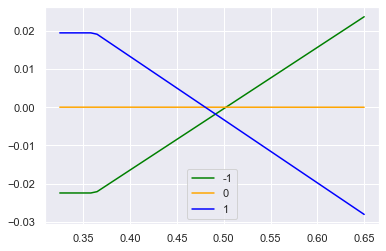

In [26]:
mid=np.array(clob["MidPrice"])
state1=(np.linspace(min(price5[5:]),max(price5[5:]))-98)/4
state2=(np.linspace(min(price20[20:]),max(price20[20:]))-98)/4
statemtx=pd.DataFrame(state1,state2).reset_index()
actdf=[]
statemtx.apply(lambda x:actdf.append(agent.model.predict(np.reshape(list(x),[1,2]))[0]),axis=1)
actdf=pd.DataFrame(actdf)
actdf.columns=["-1","0","1"]
actdf.index=(np.linspace(min(mid[5:]),max(mid[5:]))-98)/4
actdf.plot(color=["green","orange","blue"])